In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [110]:
df_train = pd.read_csv('train_aWnotuB.csv',parse_dates=[0],infer_datetime_format=True)
df_test = pd.read_csv('datasets_8494_11879_test_BdBKkAj.csv',parse_dates=[0],infer_datetime_format=True)

In [111]:
print("Size of training set: "+ str(df_train.shape))
print("Size of test set: "+ str(df_test.shape))
print('\n')
print('columns in train: '+str(df_train.columns.tolist()))
print('columns in test: '+str(df_test.columns.tolist()))

df_train.head()

Size of training set: (48120, 4)
Size of test set: (11808, 3)


columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


# QUICK EDA

In [112]:
df_tmp = df_train.set_index(['Junction','DateTime'])

In [113]:
level_values = df_tmp.index.get_level_values

In [114]:
time_targets = df_tmp.groupby([level_values(0)] + [pd.Grouper(freq='1M', level=-1)])['Vehicles'].sum()
time_targets

Junction  DateTime  
1         2015-11-30    14736
          2015-12-31    15487
          2016-01-31    17940
          2016-02-29    20813
          2016-03-31    22215
                        ...  
4         2017-02-28     5564
          2017-03-31     4931
          2017-04-30     4454
          2017-05-31     4877
          2017-06-30     6097
Name: Vehicles, Length: 66, dtype: int64

In [115]:
del df_tmp
del time_targets

# lag_features

In [116]:
train = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [117]:
train.isnull().sum()

Junction
1        0
2        0
3        0
4    10248
dtype: int64

In [118]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14592 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       14592 non-null  float64
 1   2       14592 non-null  float64
 2   3       14592 non-null  float64
 3   4       4344 non-null   float64
dtypes: float64(4)
memory usage: 570.0 KB


In [119]:
value=round(train[4].max())/1.0
value

36.0

In [120]:
train = train.fillna(value)

# Generate lag features

In [121]:
def gen_lag_features(df, n_in=1,n_out=1,dropnan=True):
    n_vars = df.shape[1]
    cols, names = list(), list()
    #input sequence (t-n,.....t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,.....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('Junction %d (H)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' %(j+1,i)) for j in range(n_vars)]
    #put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [122]:
Xy_train= gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,36.0,13.0,6.0,7.0,36.0
2015-11-01 02:00:00,13.0,6.0,7.0,36.0,10.0,5.0,5.0,36.0
2015-11-01 03:00:00,10.0,5.0,5.0,36.0,7.0,6.0,1.0,36.0
2015-11-01 04:00:00,7.0,6.0,1.0,36.0,9.0,7.0,2.0,36.0
2015-11-01 05:00:00,9.0,7.0,2.0,36.0,6.0,2.0,2.0,36.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


In [123]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
Xy_train[Xy_train.columns]= scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143,0.662252,0.702128,0.178771,0.285714
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714,0.602649,0.723404,0.167598,0.828571
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571,0.562914,0.638298,0.150838,0.428571


# Split train and valid (and normalize for real)

In [124]:
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.142857
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.200000


In [125]:
y_train= Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.200000
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.228571


# Reshape the Data

In [126]:
print(X_train.shape, y_train.shape)

(12407, 4) (12407, 4)


In [127]:
X_train = np.expand_dims(X_train.values,axis=2)
print(X_train.shape)

y_train= y_train.values
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


# Modeling

In [128]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K

def root_mean_squared_error(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [129]:
# Initialising the RNN
regressor= Sequential()

#Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,activation='relu',kernel_initializer= he_normal(seed=0),input_shape=(None,1)))

#output for 4 junctions
regressor.add(Dense(units=4))

#Compiling the RNN
regressor.compile(optimizer='adam',loss= root_mean_squared_error)

In [130]:
# Fitting the RNN to the Training set
regressor.fit(X_train,y_train,batch_size=120,epochs=100,verbose=1)

Epoch 1/100
104/104 [==============================] - 3s 4ms/step - loss: 0.1864
Epoch 2/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0434
Epoch 3/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0375
Epoch 4/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0355
Epoch 5/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0343
Epoch 6/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0334
Epoch 7/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 8/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0329
Epoch 9/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0328
Epoch 10/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 11/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 12/100
104/104 [==============================] - 0s 3ms/step - loss: 0.0326
Epoch 13/100


104/104 [==============================] - 1s 5ms/step - loss: 0.0315
Epoch 100/100
104/104 [==============================] - 1s 5ms/step - loss: 0.0315


# Validating

In [131]:
X_valid = Xy_train[Xy_train.index >='2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.142857
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.142857
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.114286
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.085714
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.085714
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571


In [34]:
X_valid=np.expand_dims(X_valid.values,axis=2)
y_pred= regressor.predict(X_valid) 

69/69 [==============================] - 0s 2ms/step


In [35]:
# we rescale y in the integer count range
# to do that we must first reconcatenate with the X data as scaler expects a shape of 8

y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred),axis=1))[:,4:]
y_pred

array([[70.87870035, 25.08252412, 26.49003682,  7.24755621],
       [65.16937718, 23.19471976, 19.85061412,  6.8374469 ],
       [53.99455801, 22.71398658, 11.54344518,  4.75872854],
       ...,
       [89.59628057, 28.75347185, 25.65579361, 27.59195542],
       [86.95860726, 28.7097193 , 24.63651659, 11.67247078],
       [81.54755408, 25.72229522, 23.51233435, 18.13860571]])

In [36]:
y_truth= train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


# Visualizing the data

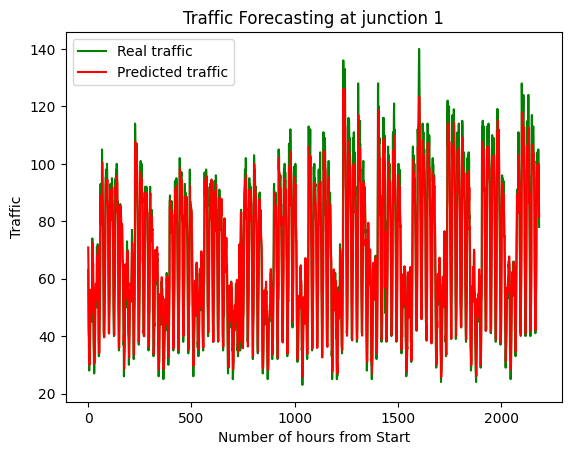

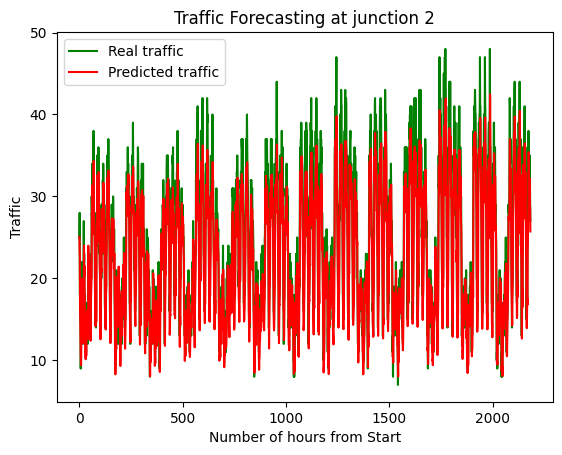

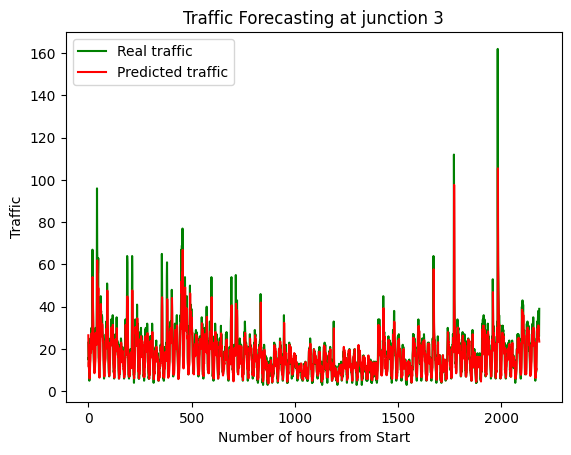

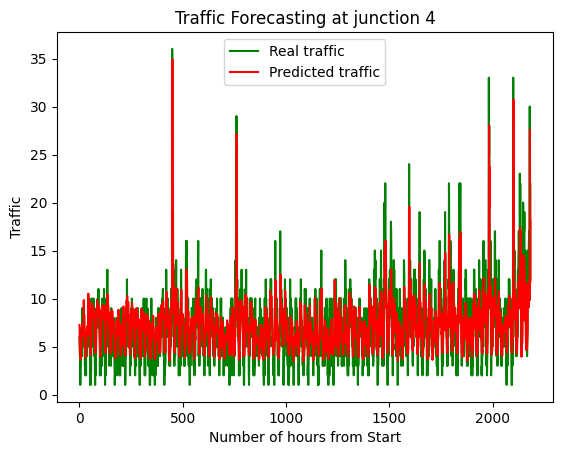

In [37]:
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction],color='green', label='Real traffic')
    plt.plot(y_pred[:,junction],color='red',label ='Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [38]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [39]:
rmse(y_truth,y_pred)

5.7660860692116325

In [43]:
import pandas as pd
import numpy as np
trdf = pd.read_csv('train_aWnotuB.csv')
trainMat= trdf.to_numpy()
tedf = pd.read_csv('datasets_8494_11879_test_BdBKkAj.csv')
testMat=tedf.to_numpy()
train=[]
target=[]
print(trainMat)
for i in trainMat:
    s=i[3]
    year=s/(10**7)
    s=s%(10**7)
    month=s/(10**5)
    s=s%(10**5)
    date=s/(10**3)
    s=s%(10**3)
    time=s/(10)
    s=s%(10)
    junction =s
    train.append([year,month,date,time,junction])
    target.append(i[2])
X= np.array(train)
y=np.array(target)

[['2015-11-01 00:00:00' 1 15 20151101001]
 ['2015-11-01 01:00:00' 1 13 20151101011]
 ['2015-11-01 02:00:00' 1 10 20151101021]
 ...
 ['2017-06-30 21:00:00' 4 16 20170630214]
 ['2017-06-30 22:00:00' 4 22 20170630224]
 ['2017-06-30 23:00:00' 4 12 20170630234]]


In [44]:
jun1=[]
jun2=[]
jun3=[]
jun4=[]
jun5=[]
jun=[jun1,jun2,jun3,jun4,jun5]
for i in range(0,len(train),24):
    ct=0
    for j in range(24):
        ct+=target[i+j]
    jun[train[i][4]-1].append(ct)
jun[3]=[0]*(len(jun[0])-len(jun[3]))+jun[3]
print(len(jun[0]),len(jun[1]),len(jun[2]),len(jun[3]))

k=7
week=[[] for i in range(k)]
for i in range(len(jun[1])):
    week[i%k].append(jun[1][i])
for i in range(k):
    print(np.mean(week[i]))
hour=[[] for i in range(24)]
for i in range(len(jun[0])*24+len(jun[1])*24, len(jun[0])*24+len(jun[1])*24+len(jun[2])*24):
    hour[i%24].append(target[i])
for i in range(24):
    print(np.mean(hour[i]))

temp=[-i for i in jun[3]]
jun[4]=np.add(jun[2],temp)

608 608 608 608
243.45977011494253
365.4942528735632
397.367816091954
394.0
384.632183908046
358.62068965517244
249.90697674418604
14.174342105263158
9.856907894736842
8.055921052631579
6.776315789473684
5.978618421052632
5.685855263157895
6.2368421052631575
7.550986842105263
9.057565789473685
11.429276315789474
15.004934210526315
17.1875
17.707236842105264
16.049342105263158
17.57236842105263
17.37171052631579
16.88157894736842
16.901315789473685
17.929276315789473
19.129934210526315
20.200657894736842
18.72203947368421
17.394736842105264
15.800986842105264


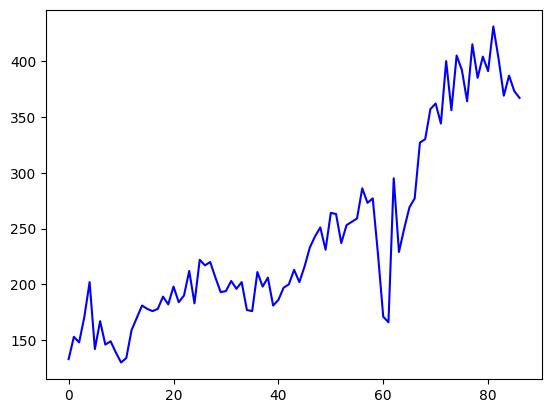

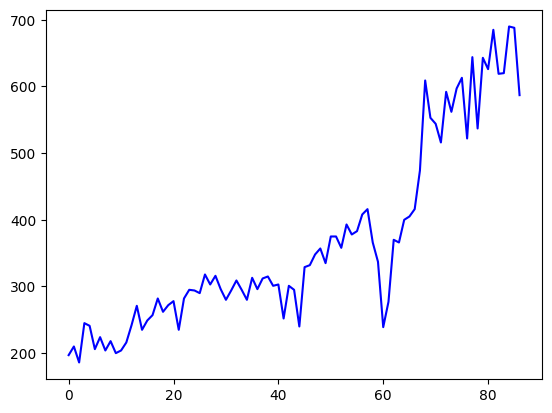

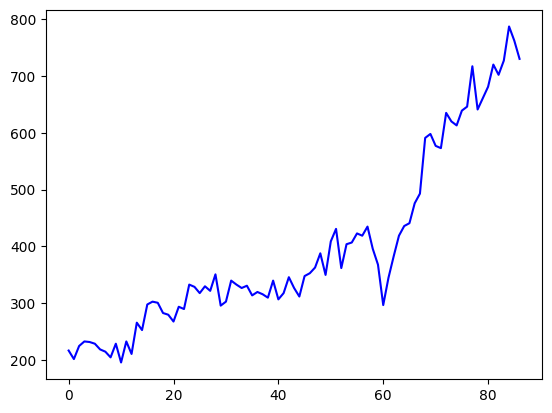

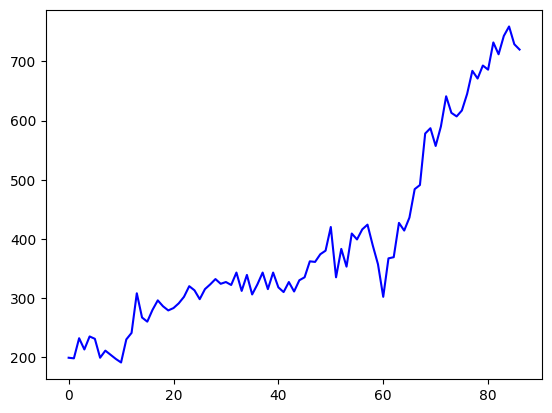

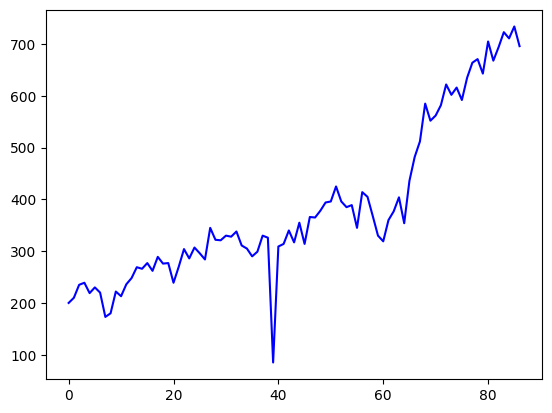

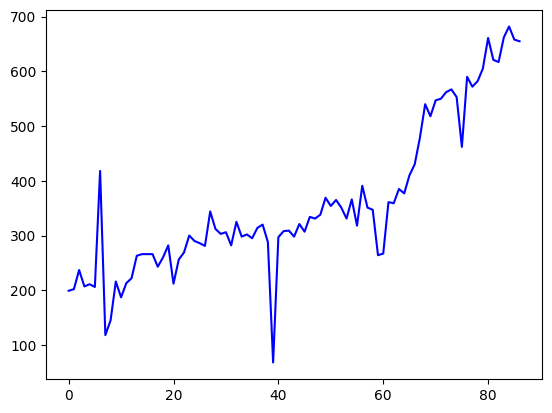

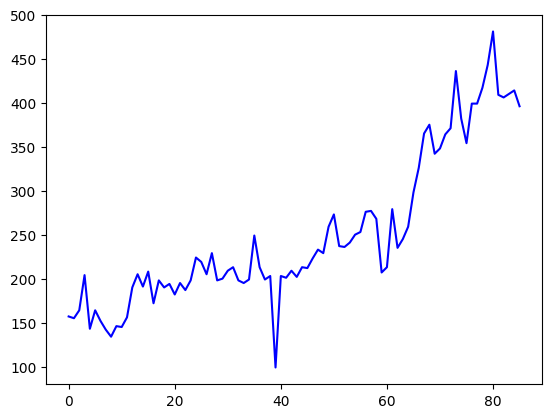

In [45]:
import matplotlib.pyplot as plt
for i in range(len(week)):
    plt.plot(week[i],'blue')
    plt.show()

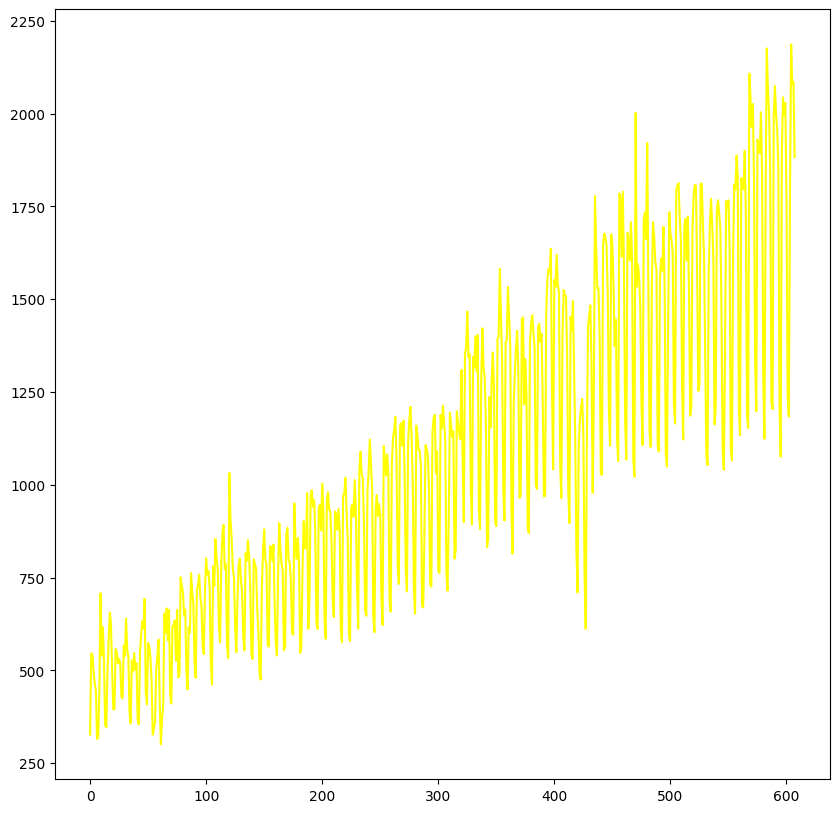

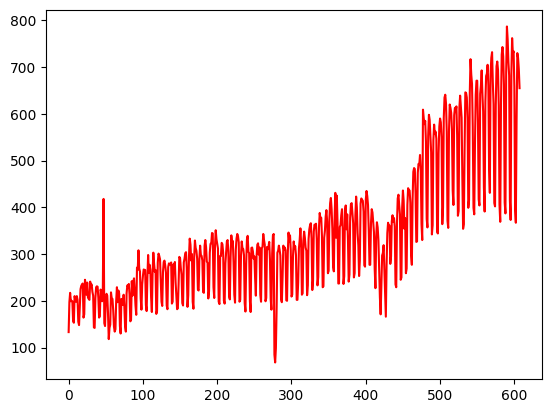

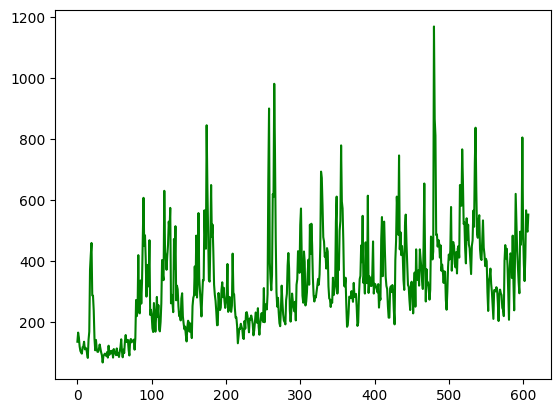

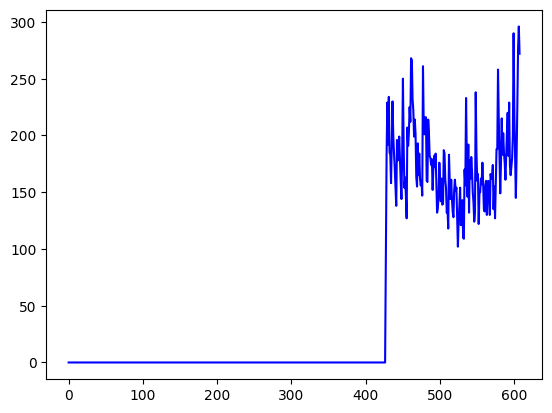

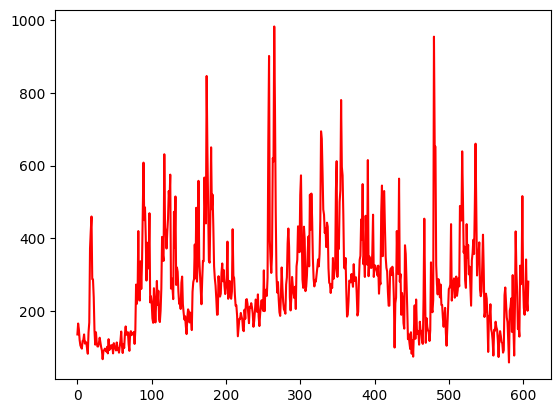

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(jun[0],'yellow')
plt.show()
plt.plot(jun[1],'red')
plt.show()
plt.plot(jun[2],'green')
plt.show()
plt.plot(jun[3],'blue')
plt.show()
plt.plot(jun[4],'red')
plt.show()

# Random Forest Classifier

In [47]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=7)
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(criterion='entropy',min_samples_split=100,min_samples_leaf=10,max_depth=12)
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [48]:
clf.fit(X,y)
pred = clf.predict(X)
val1=(accuracy_score(y,pred)*100)
print("Accuracy Score for Random Forest :",val1*5)

Accuracy Score for Random Forest : 102.81587697423107


In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse1(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [50]:
rmse1(y,pred)

7.821323986028874

# Decision Tree Classifier

In [149]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X,y)
pred2 = DT.predict(X)
val2= (accuracy_score(y,pred2)*100)
print("Accuracy score for Decision tree classifer : ",val2*5)

Accuracy score for Decision tree classifer :  500.0


In [150]:
rmse1(y,pred2)

0.0

# Support Vector Machine

In [52]:
from sklearn.svm import SVC 
SVM = SVC(kernel='linear')
SVM.fit(X,y)
pred3 = SVM.predict(X)
val3= (accuracy_score(y,pred3)*100)
print("Accuracy score for SVM : ",val3*5)

Accuracy score for SVM :  41.1783042394015


# Accuarcy of models

[Text(0, 0, 'Rf'), Text(1, 0, 'DT'), Text(2, 0, 'SVM')]

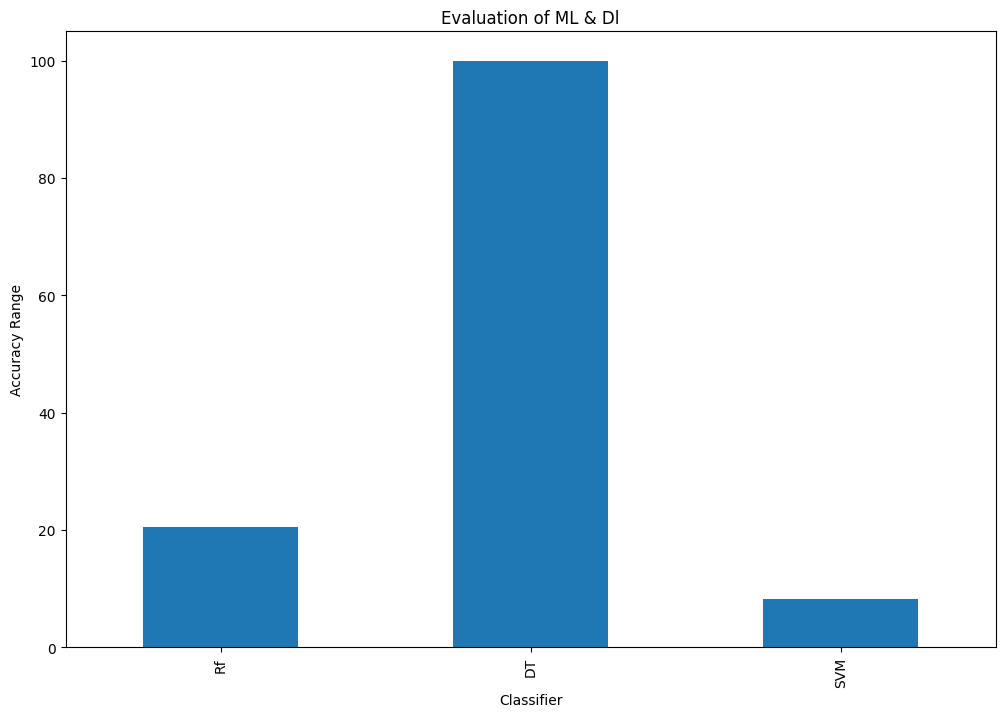

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Bring some raw data
frequencies =[val1,val2,val3]
freq_series = pd.Series(frequencies)

x_labels = ['Rf','DT','SVM']

#plot the figure
plt.figure(figsize=(12,8))
ax= freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & Dl')
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)


So from the above model evaluation we get the highest accuracy for the Decision Tree so we are going to predict the vehicles by using the decision tree classifier model

# DECISION TREE MODEL


Accuracy score for Decision Tree classifier: 500.0
MAE for Decision Tree classifier: 0.0
RMSE for Decision Tree classifier: 0.0


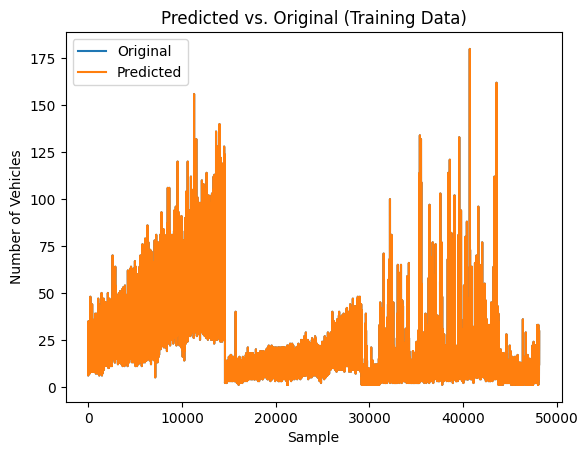

In [137]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the training data
trdf = pd.read_csv('train_aWnotuB.csv')
trainMat = trdf.to_numpy()

# Load the test data
tedf = pd.read_csv('datasets_8494_11879_test_BdBKkAj.csv')

# Prepare the training data
train = []
target = []
for i in trainMat:
    s = i[3]
    year = s // (10 ** 7)
    s = s % (10 ** 7)
    month = s // (10 ** 5)
    s = s % (10 ** 5)
    date = s // (10 ** 3)
    s = s % (10 ** 3)
    time = s // 10
    s = s % 10
    junction = s
    train.append([year, month, date, time, junction])
    target.append(i[2])
X = np.array(train)
y = np.array(target)

# Define the Decision Tree classifier
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X, y)

# Predict the values for the training data
pred_dt = clf_dt.predict(X)

# Calculate accuracy score
val_dt = accuracy_score(y, pred_dt) * 100
print("Accuracy score for Decision Tree classifier:", val_dt * 5)

# Calculate MAE and RMSE
mae_dt = mean_absolute_error(y, pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y, pred_dt))
print("MAE for Decision Tree classifier:", mae_dt)
print("RMSE for Decision Tree classifier:", rmse_dt)

# Plot the predicted values and original values for the training data
plt.plot(y, label='Original')
plt.plot(pred_dt, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Number of Vehicles')
plt.title('Predicted vs. Original (Training Data)')
plt.legend()
plt.show()

# Prepare the test data
test = []
for i in range(len(tedf)):
    s = tedf['DateTime'][i]
    year = int(s[:4])
    month = int(s[5:7])
    date = int(s[8:10])
    time = int(s[11:13])
    junction = tedf['Junction'][i]
    test.append([year, month, date, time, junction])

X_test = np.array(test)

# Predict the values for the test data
predictions = clf_dt.predict(X_test)

# Store the predicted values in a new CSV file
tedf['Vehicles'] = predictions
tedf.to_csv('predicted_values.csv', index=False)


In [152]:
p=pd.read_csv('predicted_values.csv')
p['DateTime'] = pd.to_datetime(p['DateTime'])

In [153]:
pdf = p.pivot(columns="Junction", index="DateTime",values='Vehicles')  

In [154]:
pred_dataframe_1 = pdf[1]
pred_dataframe_2 = pdf[2]  
pred_dataframe_3 = pdf[3]  
pred_dataframe_4 = pdf[4] 

# Traffic Predictions for next 4 months of given test data

Text(0.5, 0, 'Date')

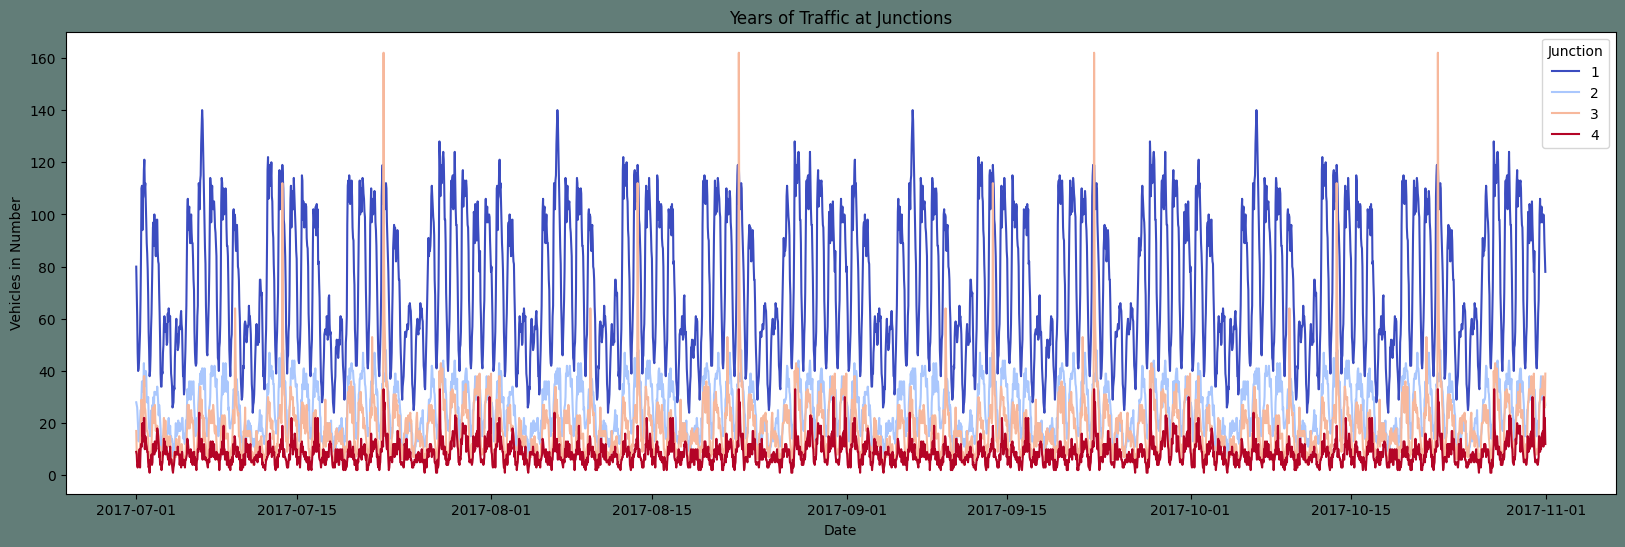

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
#timeseries plot of data
plt.figure(figsize=(20,6),facecolor="#627D78")  
Time_series=sns.lineplot(x='DateTime',y="Vehicles",data=p, hue="Junction", palette='coolwarm')  
Time_series.set_title("Years of Traffic at Junctions")  
Time_series.set_ylabel("Vehicles in Number")  
Time_series.set_xlabel("Date")

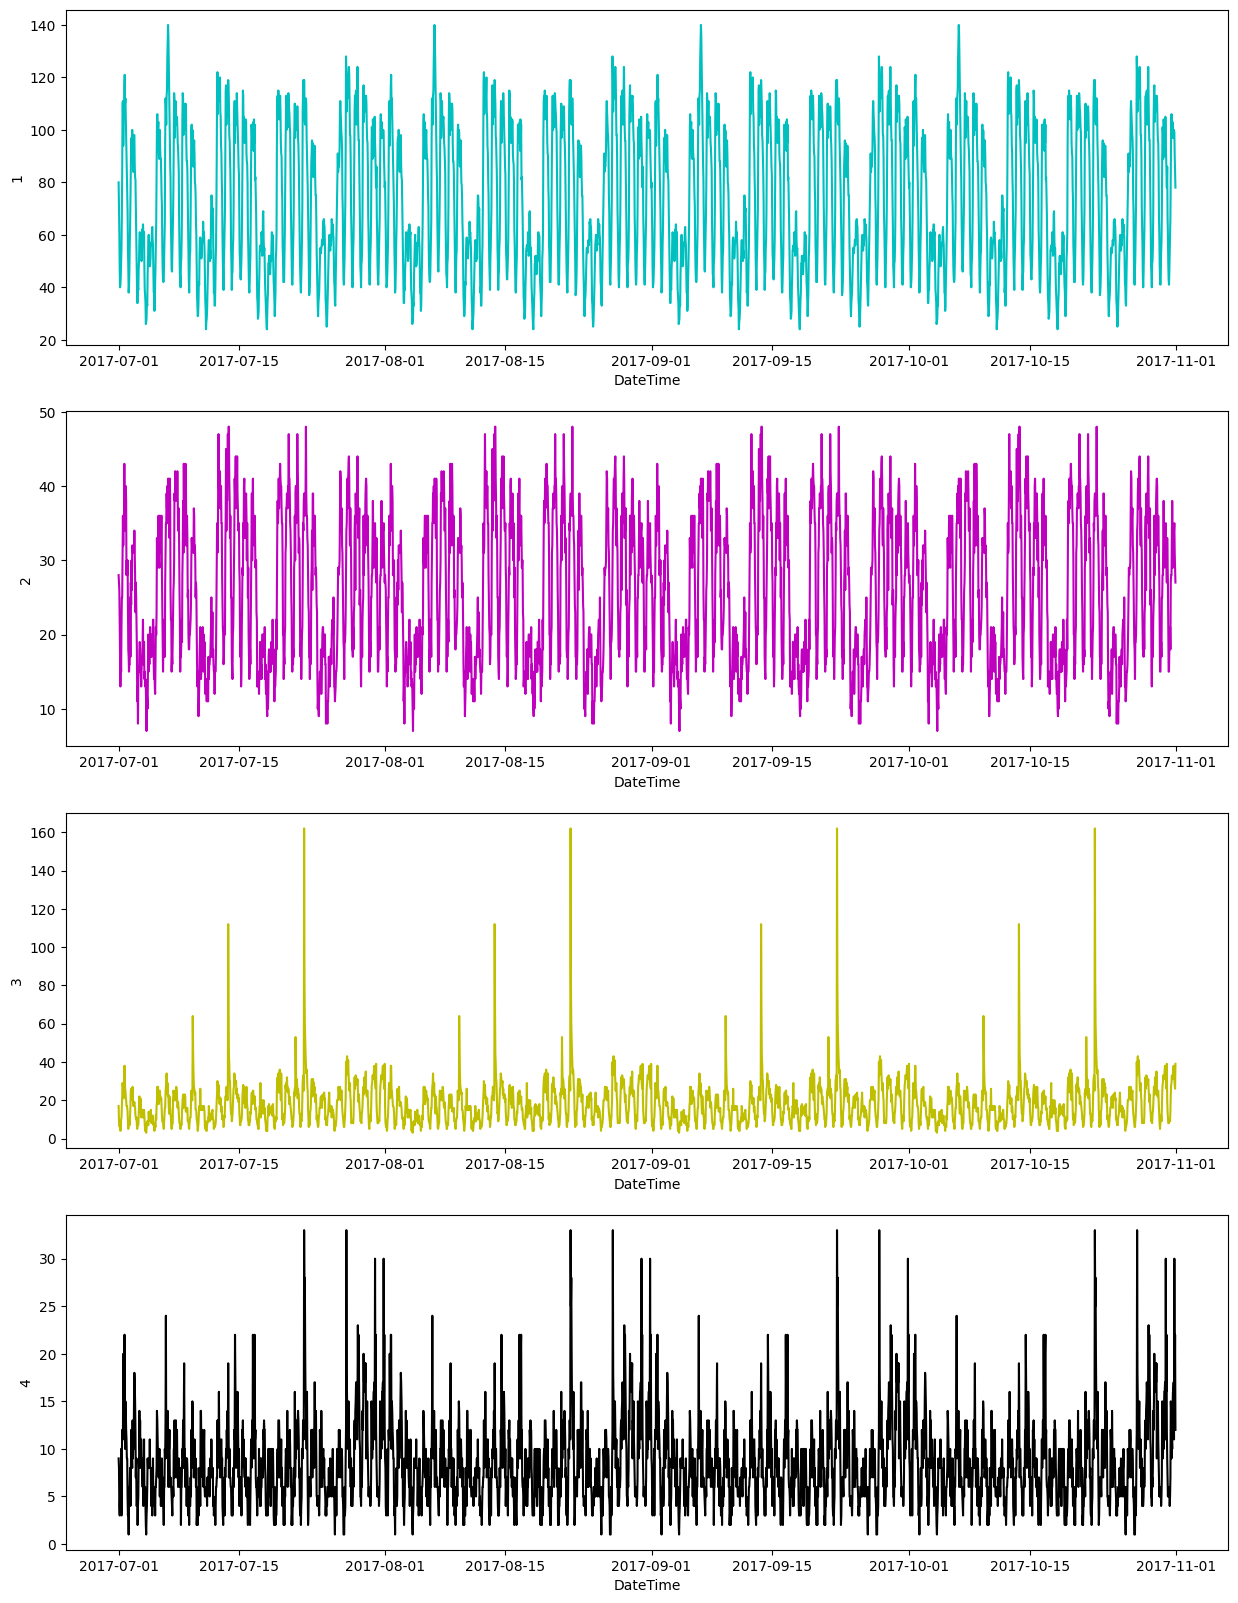

In [156]:

plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
ax=sns.lineplot(data=pred_dataframe_1,color='c')

plt.subplot(4,1,2)
ax=sns.lineplot(data=pred_dataframe_2,color='m')

plt.subplot(4,1,3)
ax=sns.lineplot(data=pred_dataframe_3,color='y')

plt.subplot(4,1,4)
ax=sns.lineplot(data=pred_dataframe_4,color='k')

ax=sns.lineplot()